In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import product

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
id='1A05tV8ylCXt2bsr4N6FCFiW9aN8IeHpt'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('tweets-test.csv')

id='1QmKZzdrnNfSZ0RWrW89d6V_SG8cp03AK'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('tweets-train.csv')

id='10eZt-KLAOXDogmq9gEAUmcRkabhvV8UG'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('retweets-test.csv')

id='1_pp8dvoiEjWRRAu48KwcSYBsTcLKywUU'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('retweets-train.csv')

In [4]:
tweets_train = pd.read_csv('tweets-train.csv')
tweets_train['rel'] = 1
print(tweets_train.shape)
tweets_train.head(10)


(213823, 9)


,Unnamed: 0,article_id,tweet_id,tweet_created_at,retweet_count,user_id,cold_user,test,rel
0,1030,politifact13013,771487002575286273,2016-09-01 23:16:49+00:00,0,313584104,1,0,1
1,1031,politifact13013,771271973229826048,2016-09-01 09:02:22+00:00,0,10480592,1,0,1
2,1032,politifact13013,771288677557280768,2016-09-01 10:08:45+00:00,0,175844074,1,0,1
3,1033,politifact13013,771223329214566400,2016-09-01 05:49:04+00:00,0,2577100238,1,0,1
4,1034,politifact13013,771475597918740481,2016-09-01 22:31:30+00:00,0,453088398,1,0,1
5,1035,politifact13013,771497379489021952,2016-09-01 23:58:03+00:00,0,2545443218,1,0,1
6,1036,politifact13013,771271247271436288,2016-09-01 08:59:29+00:00,0,4007486653,1,0,1
7,1037,politifact13013,771078869596053504,2016-08-31 20:15:03+00:00,0,2547704588,1,0,1
8,1038,politifact13013,771095395086643200,2016-08-31 21:20:43+00:00,0,179752508,1,0,1
9,1039,politifact13013,771281620321996800,2016-09-01 09:40:42+00:00,0,69533246,0,0,1


In [5]:
tweets_test = pd.read_csv('tweets-test.csv')
tweets_test['rel'] = 1
print(tweets_test.shape)
tweets_test.head(10)

(73886, 9)


,Unnamed: 0,article_id,tweet_id,tweet_created_at,retweet_count,user_id,cold_user,test,rel
0,1057,politifact13013,771500686433357824,2016-09-02 00:11:12+00:00,0,69533246,0,1,1
1,1952,politifact100,1061258447721775105,2018-11-10 14:05:05+00:00,0,44385059,1,1,1
2,1956,politifact100,998291600395636736,2018-05-20 19:57:19+00:00,15,2587603297,0,1,1
3,1957,politifact100,1065068855129763840,2018-11-21 02:26:17+00:00,0,581997381,0,1,1
4,1964,politifact100,1025389438699024384,2018-08-03 14:34:27+00:00,0,54317462,0,1,1
5,1970,politifact100,1050809582547857408,2018-10-12 18:05:02+00:00,0,917812611336503298,0,1,1
6,1971,politifact100,1014921845202669574,2018-07-05 17:19:58+00:00,4,928829323,0,1,1
7,1974,politifact100,1044011696656793600,2018-09-23 23:52:39+00:00,0,720093010420244481,0,1,1
8,1977,politifact100,1061259696714211328,2018-11-10 14:10:03+00:00,0,4183188317,1,1,1
9,1988,politifact100,1057954012585230336,2018-11-01 11:14:27+00:00,0,3951353237,1,1,1


In [6]:
all_docs_list = np.concatenate((np.unique(tweets_train['article_id']), np.unique(tweets_train['article_id'])) , axis=0)
all_docs = pd.DataFrame(set(all_docs_list), columns=['article_id'])
all_docs.head()

,article_id
0,politifact12773
1,politifact245
2,politifact1424
3,politifact6556
4,politifact7511


In [17]:
len(np.unique(tweets_test['article_id']))

326

In [18]:
print(tweets_train.shape)
tweets_train = pd.merge(tweets_train, all_docs, on='article_id', how='outer')
print(tweets_train.shape)


(213823, 9)
(213823, 9)


In [19]:
R = tweets_train.copy()
R = R[['user_id', 'article_id', 'rel']]
R = R.pivot_table(index='user_id', columns='article_id', values='rel', fill_value=0 )
R.shape


(149824, 326)

In [20]:
print(tweets_test.shape)
tweets_test = pd.merge(tweets_test, all_docs, on='article_id', how='right')
print(tweets_test.shape)


(73986, 9)
(73986, 9)


In [0]:
R_test = tweets_test.copy()
R_test = R_test[['user_id', 'article_id', 'rel']]
R_test = R_test.pivot_table(index='user_id', columns='article_id', values='rel', fill_value=0 )
R_test.shape


In [24]:
R.head()

article_id,politifact100,politifact1014,politifact10185,politifact10209,politifact1026,politifact10276,politifact1028,politifact10332,politifact10348,politifact10371,politifact1038,politifact10408,politifact1047,politifact1052,politifact1053,politifact10533,politifact1067,politifact10787,politifact10877,politifact10903,politifact10945,politifact11021,politifact11066,politifact11115,politifact1118,politifact11189,politifact11208,politifact11314,politifact11399,politifact11416,politifact11552,politifact11580,politifact1161,politifact11627,politifact11709,politifact11761,politifact11770,politifact11777,politifact118,politifact1180,...,politifact8152,politifact8172,politifact8221,politifact825,politifact8259,politifact8310,politifact834,politifact8470,politifact8537,politifact8557,politifact8611,politifact8621,politifact8737,politifact8778,politifact8805,politifact8838,politifact8846,politifact8989,politifact9033,politifact910,politifact9107,politifact934,politifact937,politifact938,politifact939,politifact943,politifact9438,politifact951,politifact9512,politifact954,politifact9576,politifact959,politifact9622,politifact9691,politifact979,politifact98,politifact9802,politifact986,politifact99,politifact997
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
41,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
785,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
np.sum(R)

article_id
politifact100      1924
politifact1014        2
politifact10185      93
politifact10209     681
politifact1026        6
                   ... 
politifact98        103
politifact9802       89
politifact986         7
politifact99       1664
politifact997         3
Length: 326, dtype: int64

In [26]:
"""R = tweets.copy()
R = R[['user_id', 'article_id', 'rel']]
R = R.pivot_table(index='user_id', columns='article_id', values='rel', fill_value=0 )

X = R
distorsions = []
for k in range(100, 220):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')"""

"R = tweets.copy()\nR = R[['user_id', 'article_id', 'rel']]\nR = R.pivot_table(index='user_id', columns='article_id', values='rel', fill_value=0 )\n\nX = R\ndistorsions = []\nfor k in range(100, 220):\n    kmeans = KMeans(n_clusters=k)\n    kmeans.fit(X)\n    distorsions.append(kmeans.inertia_)\n\nfig = plt.figure(figsize=(15, 5))\nplt.plot(range(2, 20), distorsions)\nplt.grid(True)\nplt.title('Elbow curve')"

In [0]:
kmeans = KMeans(n_clusters=200, random_state=0).fit(R)

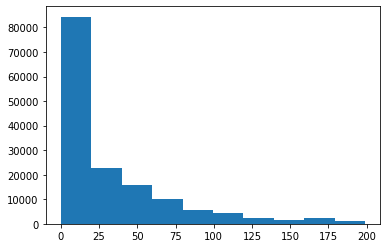

In [30]:
plt.hist(kmeans.labels_)
plt.show()

In [0]:
R['cluster'] = kmeans.labels_
final_result = R[['cluster']]
final_result.to_csv('k_means_tweet_train.csv')

In [32]:
R_test['cluster'] = kmeans.transform(R_test)
final_result = R_test[['cluster']]
final_result.to_csv('k_means_tweet_test.csv')

ValueError: ignored

In [14]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000)
    
    pca = PCA(n_components=2).fit_transform(data)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data))
    
    
    idx = np.random.choice(range(pca.shape[0]),size=515, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(R, kmeans.labels_)

IndexError: ignored

In [0]:
#
# Author: Stanislaw Adaszewski, 2015
#

import networkx as nx
import numpy as np
import time


def constrained_kmeans(data, demand, maxiter=None, fixedprec=1e9):
	data = np.array(data)
	
	min_ = np.min(data, axis = 0)
	max_ = np.max(data, axis = 0)
	
	C = min_ + np.random.random((len(demand), data.shape[1])) * (max_ - min_)
	M = np.array([-1] * len(data), dtype=np.int)
	
	itercnt = 0
	while True:
		itercnt += 1
		
		# memberships
		g = nx.DiGraph()
		g.add_nodes_from(range(0, data.shape[0]), demand=-1) # points
		for i in range(0, len(C)):
			g.add_node(len(data) + i, demand=demand[i])
		
		# Calculating cost...
		cost = np.array([np.linalg.norm(np.tile(data.T, len(C)).T - np.tile(C, len(data)).reshape(len(C) * len(data), C.shape[1]), axis=1)])
		# Preparing data_to_C_edges...
		data_to_C_edges = np.concatenate((np.tile([range(0, data.shape[0])], len(C)).T, np.tile(np.array([range(data.shape[0], data.shape[0] + C.shape[0])]).T, len(data)).reshape(len(C) * len(data), 1), cost.T * fixedprec), axis=1).astype(np.uint64)
		# Adding to graph
		g.add_weighted_edges_from(data_to_C_edges)
		

		a = len(data) + len(C)
		g.add_node(a, demand=len(data)-np.sum(demand))
		C_to_a_edges = np.concatenate((np.array([range(len(data), len(data) + len(C))]).T, np.tile([[a]], len(C)).T), axis=1)
		g.add_edges_from(C_to_a_edges)
		
		
		# Calculating min cost flow...
		f = nx.min_cost_flow(g)
		
		# assign
		M_new = np.ones(len(data), dtype=np.int) * -1
		for i in range(len(data)):
			p = sorted(f[i].iteritems(), key=lambda x: x[1])[-1][0]
			M_new[i] = p - len(data)
			
		# stop condition
		if np.all(M_new == M):
			# Stop
			return (C, M, f)
			
		M = M_new
			
		# compute new centers
		for i in range(len(C)):
			C[i, :] = np.mean(data[M==i, :], axis=0)
			
		if maxiter is not None and itercnt >= maxiter:
			# Max iterations reached
			return (C, M, f)


In [15]:
X.shape[0]/200

997.635

In [16]:
X.shape[0] - 997*200

127

In [17]:
X.shape[0]

199527

In [0]:
demand = np.repeat(997,200)
demand = np.append(demand,127)

In [19]:
np.sum(demand) - X.shape[0]

0

In [0]:
data = X
t = time.time()
(C, M, f) = constrained_kmeans(data, demand=demand)

print('C:', C)
print('M:', M)

data['cluster'] = C
final_result = data[['cluster']]
final_result.to_csv('k_means_balanced.csv')